In [68]:
import scipy.stats
from sklearn.metrics import mean_squared_error
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('dark_background')

In [ ]:
# # Load data:
# regression_results = pd.read_csv("../results/multioutput/regression/regr_results_all_feat.csv", index_col=0)
# mol_feat = pd.read_csv("../results/multioutput/regression/regr_results_mol_feat.csv", index_col=0)
# fingerprint_feat = pd.read_csv("../results/multioutput/regression/regr_results_fingerprints.csv", index_col=0)
#
#
# regression_results = regression_results.rename(columns={"prediction": "pred_all_feat"})
# regression_results["pred_mol_feat"] = mol_feat["prediction"]
# regression_results["pred_fingerprints_feat"] = fingerprint_feat["prediction"]
#
# regression_results = regression_results.rename(columns={"pred_all_feat": "prediction"})

In [93]:
# Alternative data:
regression_results = pd.read_csv("../results/multioutput/regression/regr_results_single_mol_feat.csv", index_col=0)


In [94]:
# regression_results


In [95]:
# compute Spearman's/Pearson's correlation and mean squared error for each matrix/polarity/regressor
regression_metrics = pd.DataFrame(columns = ['matrix', 'polarity', 'regressor', "Spearman's R", 
                                             'S pval', "Pearson's R", 'P pval', 'RMSE', 'RMSE/std', 'non-zero obs'])
counter = 0
for (matrix, polarity, regressor), rows in regression_results.groupby(['matrix', 'polarity', 'regressor']):
    # remove zero intensity molecules if needed (optional)
    rows = rows[rows['observed_value']!=0]
    
    spearman = scipy.stats.spearmanr(rows.observed_value, rows.prediction)
    pearson = scipy.stats.pearsonr(rows.observed_value, rows.prediction)
    mse = mean_squared_error(rows.observed_value, rows.prediction, squared = False)
    mse_std = mse / rows['observed_value'].std()
    regression_metrics.loc[counter] = [matrix, polarity, regressor, spearman[0], spearman[1], 
                                       pearson[0], pearson[1], mse, mse_std, 
                                       rows[rows['observed_value']!=0].shape[0]]
    counter += 1

In [96]:
regression_metrics

,matrix,polarity,regressor,Spearman's R,S pval,Pearson's R,P pval,RMSE,RMSE/std,non-zero obs
0,9AA,negative,RandomForest,0.669391,4.658490e-23,0.656154,6.280461e-22,1.750352,0.797963,167
1,9AA,positive,RandomForest,0.518098,2.082237e-08,0.522583,1.495031e-08,1.510140,0.926301,103
2,CHCA,negative,RandomForest,0.430418,7.517771e-05,0.386598,4.327357e-04,1.244300,0.976899,79
3,CHCA,positive,RandomForest,0.350506,1.063789e-11,0.364931,1.267144e-12,1.365797,0.967926,355
4,CMBT,negative,RandomForest,0.440814,5.993521e-04,-0.045414,7.372901e-01,0.625490,1.121271,57
5,CMBT,positive,RandomForest,0.284704,1.815188e-06,0.292669,8.989066e-07,1.120858,1.005421,272
6,ClCCA,negative,RandomForest,0.475074,8.344585e-05,0.248643,4.941371e-02,0.367619,1.014330,63
7,ClCCA,positive,RandomForest,0.269045,1.798858e-07,0.270316,1.566078e-07,0.861162,0.994085,365
8,DAN,negative,RandomForest,0.438244,1.176748e-08,0.396854,3.182341e-07,1.045824,0.973521,155
9,DAN,positive,RandomForest,0.450516,7.670734e-12,0.480312,1.845752e-13,0.974929,0.918148,209


In [97]:
# select best regressor for each matrix/polarity combination
best_RMSE = regression_metrics.loc[regression_metrics.groupby(['matrix', 'polarity'])["RMSE/std"].idxmin()]
#best_RMSE

best_spear = regression_metrics.loc[regression_metrics.groupby(['matrix', 'polarity'])["Spearman's R"].idxmax()].sort_values("Spearman's R", ascending=False)
best_spear

,matrix,polarity,regressor,Spearman's R,S pval,Pearson's R,P pval,RMSE,RMSE/std,non-zero obs
0,9AA,negative,RandomForest,0.669391,4.658490e-23,0.656154,6.280461e-22,1.750352,0.797963,167
16,NOR,negative,RandomForest,0.595889,1.085799e-15,0.534206,2.277816e-12,1.436395,0.913500,149
1,9AA,positive,RandomForest,0.518098,2.082237e-08,0.522583,1.495031e-08,1.510140,0.926301,103
12,DHB,negative,RandomForest,0.476807,3.444786e-05,0.520521,4.547772e-06,0.885627,0.914496,69
6,ClCCA,negative,RandomForest,0.475074,8.344585e-05,0.248643,4.941371e-02,0.367619,1.014330,63
9,DAN,positive,RandomForest,0.450516,7.670734e-12,0.480312,1.845752e-13,0.974929,0.918148,209
4,CMBT,negative,RandomForest,0.440814,5.993521e-04,-0.045414,7.372901e-01,0.625490,1.121271,57
8,DAN,negative,RandomForest,0.438244,1.176748e-08,0.396854,3.182341e-07,1.045824,0.973521,155
2,CHCA,negative,RandomForest,0.430418,7.517771e-05,0.386598,4.327357e-04,1.244300,0.976899,79
17,NOR,positive,RandomForest,0.407529,8.869429e-08,0.345892,7.464620e-06,1.459803,1.004114,160


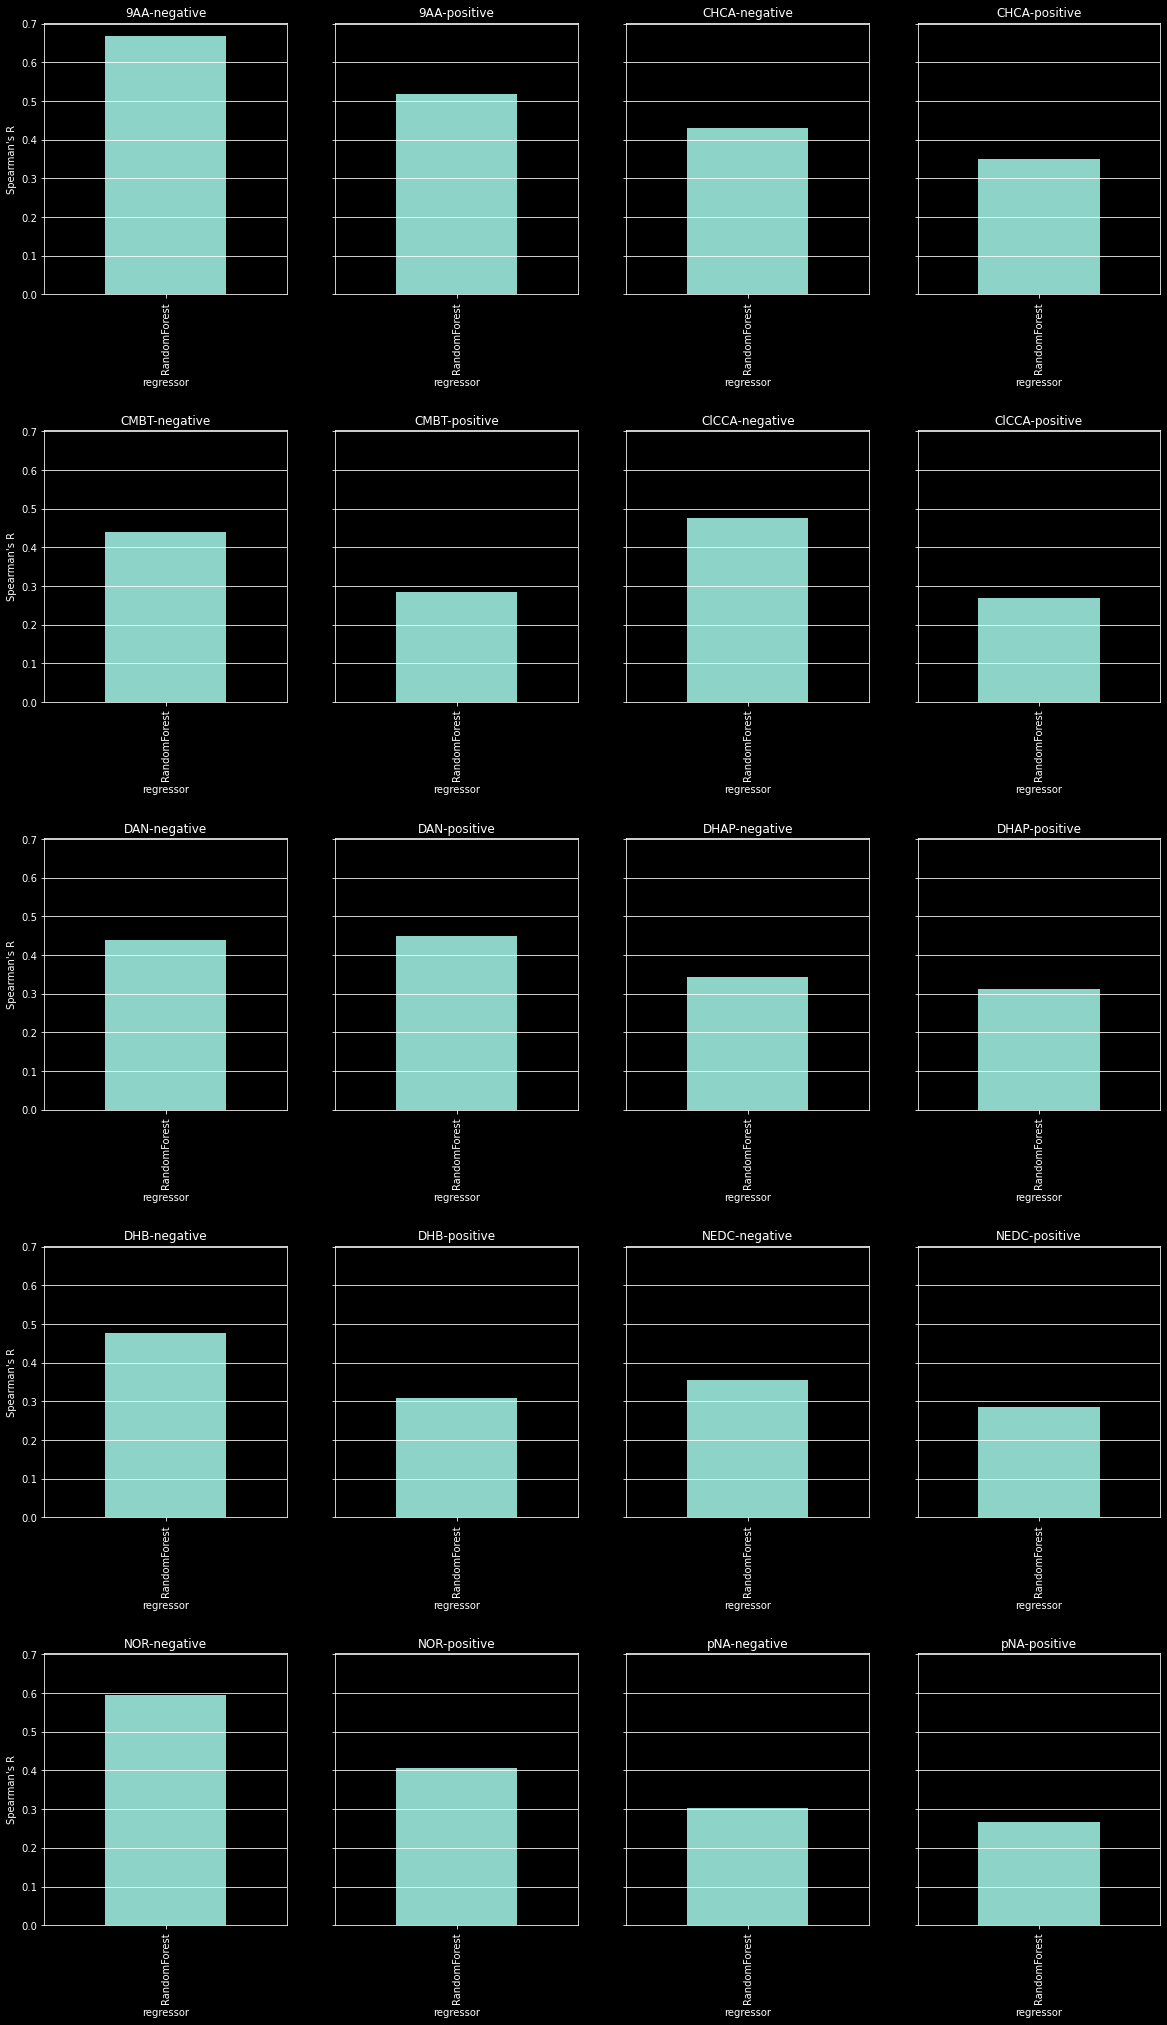

In [98]:
fig, axes = plt.subplots(ncols=4,nrows=5, sharey=True, figsize= (20, 35))
ax_list = axes.flat

metric = "Spearman's R"
#metric = "RMSE"

i = 0
for (matrix, polarity), rows in regression_metrics.groupby(['matrix', 'polarity']):
    rows = rows.set_index('regressor', drop = True).sort_values( by = metric)
    rows[metric].plot.bar(ax = ax_list[i], title=f"{matrix}-{polarity}")
    ax_list[i].set_ylabel(metric)
    ax_list[i].grid(axis='y')
    i+=1

plt.subplots_adjust(hspace=0.5)

plt.show()

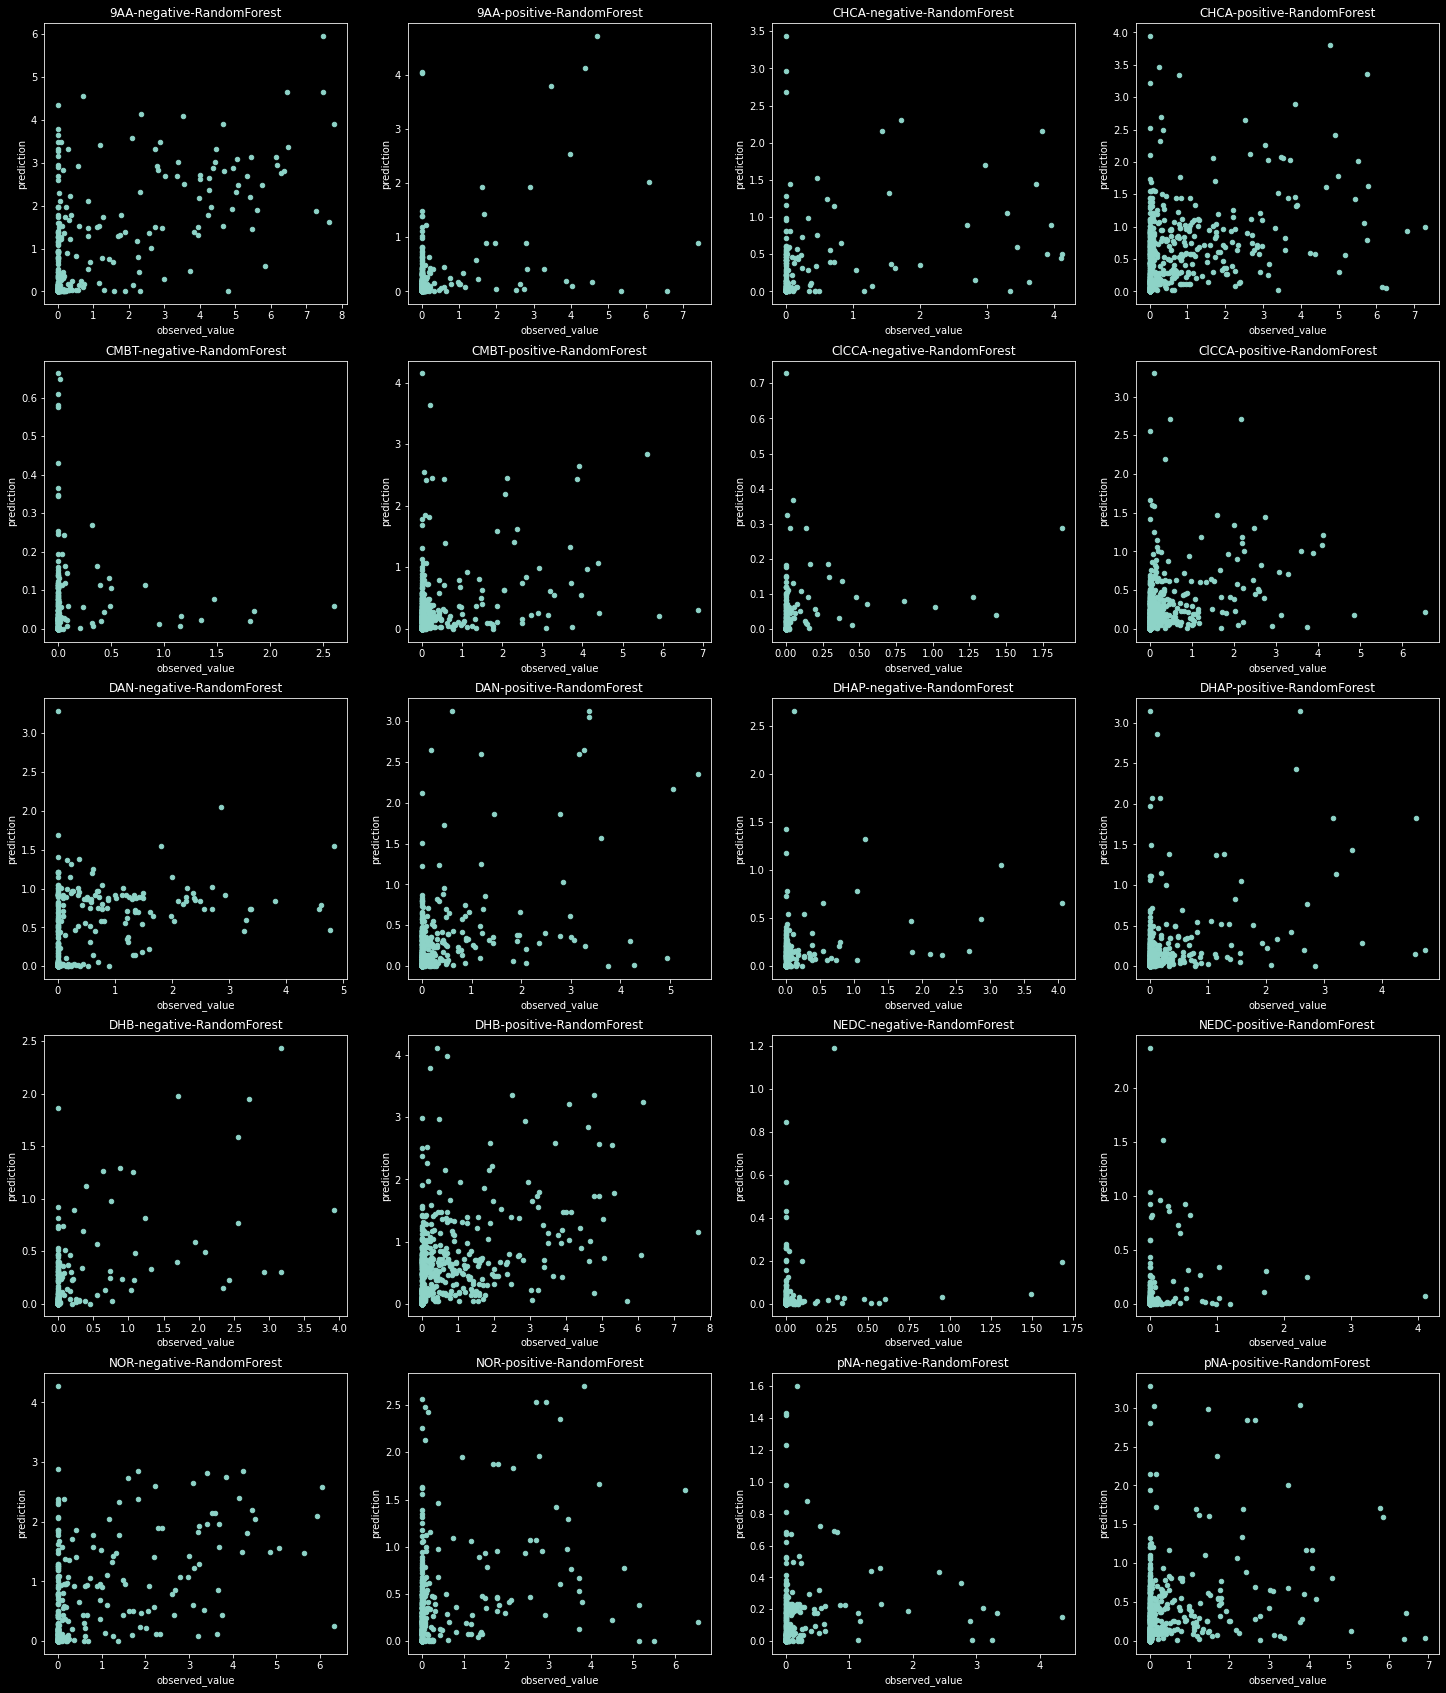

In [100]:
fig, axes = plt.subplots(ncols=4,nrows=5, figsize= (25, 30))
ax_list = axes.flat

regressor = "RandomForest"

i = 0
for (matrix, polarity), rows in regression_results.groupby(['matrix', 'polarity']):
    rows[rows.regressor == regressor].plot.scatter(x = 'observed_value', y= 'prediction',
                                                   ax = ax_list[i], title=f"{matrix}-{polarity}-{regressor}")
    i+=1

plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.show()

### Matrix prediction accuracy
Check if the best matrix is selected for each ion with a selected regressor


Ignore molecules that were never observed

In [83]:
# Get rid of molecules that were never detected from results dt:
g = regression_results.groupby(['name_short', 'adduct'], as_index=False)["observed_value"].max()
regression_results = pd.merge(regression_results, g[g["observed_value"] >= 0.][["adduct", "name_short"]],
        how="inner")

accuracy_df = pd.DataFrame(columns = ['regressor', 'accuracy'])
for i, selected_regressor in enumerate(regression_results["regressor"].unique()):
    accuracy = 0
    for (molecule, adduct), rows in regression_results[regression_results.regressor == selected_regressor].groupby(['name_short', 'adduct']):
        # print(rows["observed_value"].idxmax(), rows.loc[rows["observed_value"].idxmax(), ["matrix", "polarity"]])
        best_observed = rows.loc[rows["observed_value"].idxmax(), ["matrix", "polarity"]]
        # Warning: idxmax() returns the first row (even in case of ties)
        best_predicted = rows.loc[rows["prediction"].idxmax()][["matrix", "polarity"]]

        # If all observed intensities were zeros, let's check if all predicted intensities were also low:
        if rows["observed_value"].max() <= 0.:
            # FIXME: for the moment we use arbitrary number
            # print(rows["prediction"].max())
            if rows["prediction"].max() <= 0.05: accuracy += 1
        else:
            if (best_observed == best_predicted).all(): accuracy += 1
        # else:
        #     print("Warning: multiple predictions with same intensity")
        #     if len(pd.merge(best_observed, best_predicted)) > 0: accuracy += 1

    accuracy = accuracy / regression_results[regression_results.regressor == selected_regressor][['name_short', 'adduct']].drop_duplicates().shape[0]
    accuracy_df.loc[i] = [selected_regressor, accuracy]


In [40]:
accuracy_df.sort_values("accuracy", ascending=False)

,regressor,accuracy
4,KNeighbors,0.288250
5,DecisionTree,0.229924
7,RandomForest,0.229079
6,DecisionTreeMultiOut,0.204565
8,RandomForestMultiOut,0.164835
0,Lin_reg,0.046492
1,Lin_regMultiOut,0.046492
11,GaussianProcess,0.046492
12,GaussianProcessMultiOut,0.046492
10,MLPMultiOut,0.028740
